# Validation Thresholds

The validation thresholds for Gemma-3-27B were computed following the standard validation threshold computation methodology. Full details of this process are documented in [`proposals/models/README.md`](../README.md).

This notebook suggest an analysis part given the precomputed raw data from inference-validation cycles. You can reproduce this analysis here. 

If you want to reproduce the full procedure, including the inference-validation cycles, you'll need to refer to the [`proposals/models/README.md`](../README.md) and learn there how to conduct the inference part.

The `inference.py` that produced the raw data for this analysis can be found here: [link](https://github.com/gonka-ai/gonka/blob/1a531d772907ea9253c028d544819a4b0d25d011/mlnode/packages/benchmarks/scripts/inference.py) 

## Overview

Key results of this experiments are:
- **Validation threshold lower and upper bounds**: `0.040`, `0.041`
- **Fraud Detection Rate**: **99%**

These thresholds ensure robust fraud detection while accommodating legitimate hardware-induced variations in probability distributions.

All inference-validation cycle results, including full JSONL datasets and configuration files, are available in the shared Google Drive folder [Gemma-3-27B Validation Data](https://drive.google.com/drive/folders/1RLlzLdTUj1vroQuD878Lr7wuEb3erCQZ?usp=sharing), which includes a) Complete inference-validation JSONL files (~17-80MB per configuration); b) Configuration JSON files for each run.  

IMPORTANT: if you want the code below to work, you'll need to download the files and define the path to this files below.

**GDrive with data**: [Gemma-3-27B Validation Data](https://drive.google.com/drive/folders/1RLlzLdTUj1vroQuD878Lr7wuEb3erCQZ?usp=sharing)

## Data preparation

Below is the analysis code for the resulting raw data from inference-validation cycles.

To be able to analyse the results yourself, you need:
1. Download the raw data and configs
2. Put all the files, including raw data and configs to one place
3. Set `gonka_path` (path to the gonka project) and `data_path` (path to the folder containining downloaded data) correctly to be able to import the code and files.
4. Run the code cells

In [1]:
%load_ext autoreload
%autoreload 2
gonka_path = '/root/gonka'

import sys
import os
sys.path.append(os.path.join(gonka_path, 'mlnode/packages/benchmarks/src'))
sys.path.append(os.path.join(gonka_path, 'mlnode/packages/common/src'))
import os
import copy
import numpy as np

from validation.data import load_from_jsonl

from validation.analysis import generate_name_from_config, find_optimal_bounds_parallel, evaluate_bound, classify_data
from validation.analysis import analyze, process_data, plot_classification_results, plot_length_vs_distance_comparison
from validation.analysis import plot_violin_comparison

### Test Configurations

**Honest inference scenarios** test the acceptable distance range when both inference and validation use the same model (FP8 precision):
1. **1xH100 vs 1xH100**: Primary scenario
2. **4x3090 vs 1xH100**: Cross-hardware validation
3. **4x3090 vs 4x3090**: Same-hardware validation

**Fraudulent Inference Scenarios** test fraud detection capability when inference uses an INT4 quantization ([gemma-3-27b-it-GPTQ-4b-128g](https://huggingface.co/ISTA-DASLab/gemma-3-27b-it-GPTQ-4b-128g)) while validation uses the correct FP8 model ([gemma-3-27b-it-FP8-dynamic](https://huggingface.co/RedHatAI/gemma-3-27b-it-FP8-dynamic)). 
1. **1xH100 (INT4) vs 1xH100 (FP8)**: Primary fraud detection test
2. **4x3090 (INT4) vs 1xH100 (FP8)**: Cross-hardware fraud detection
3. **4x3090 (INT4) vs 4x3090 (FP8)**: Cross-hardware fraud detection

Below you'll see how each test scenarios' raw file is loaded.

In [2]:
model_name = 'gemma27B'

##### This part should be changed according to the path where json files are generated or downloaded #######
data_path = os.path.join(gonka_path, 'mlnode/packages/benchmarks/data/inference_results')


honest_data_paths = [
    os.path.join(data_path, 'gemma-3-27b-it-FP8-dynamic-fp8-1xH100___gemma-3-27b-it-FP8-dynamic-fp8-1xH100__gemma27B__2025-11-03_2048.jsonl'),
    os.path.join(data_path, 'gemma-3-27b-it-FP8-dynamic-fp8-4x3090___gemma-3-27b-it-FP8-dynamic-fp8-1xH100__gemma27B__2025-11-03_2136.jsonl'),
    os.path.join(data_path, 'gemma-3-27b-it-FP8-dynamic-fp8-4x3090___gemma-3-27b-it-FP8-dynamic-fp8-4x3090__gemma27B__2025-11-03_2143.jsonl')
]

fraud_data_paths = [
    os.path.join(data_path, 'gemma-3-27b-it-GPTQ-4b-128g-int4-1xH100___gemma-3-27b-it-FP8-dynamic-fp8-1xH100__gemma27B__2025-11-03_2102.jsonl'),
    os.path.join(data_path, 'gemma-3-27b-it-GPTQ-4b-128g-int4-4x3090___gemma-3-27b-it-FP8-dynamic-fp8-1xH100__gemma27B__2025-11-03_2119.jsonl'),
    os.path.join(data_path, 'gemma-3-27b-it-GPTQ-4b-128g-int4-4x3090___gemma-3-27b-it-FP8-dynamic-fp8-4x3090__gemma27B__2025-11-03_2127.jsonl')    
]
##############################################################################################################

#generate_name_from_config looks for a config file in the same folder, where the raw data is
DATA_PATH = {generate_name_from_config(dp, model_name): dp for dp in honest_data_paths + fraud_data_paths}

Below are some preparation steps: get the distances and items from the raw data

In [3]:
honest_items_dict, honest_distances_dict = {}, {}
fraud_items_dict, fraud_distances_dict = {}, {}
honest_distances, fraud_distances = [], []

for name, path in DATA_PATH.items():
    items, distances, topk = process_data(load_from_jsonl(path, n=1000))
    if 'honest' in name:
        honest_items_dict[name] = items
        honest_distances_dict[name] = distances
        honest_distances.extend(distances)
    if 'fraud' in name:
        fraud_items_dict[name] = items
        fraud_distances_dict[name] = distances
        fraud_distances.extend(distances)

Dropped 0 / 1000 items
Dropped 0 / 200 items
Dropped 0 / 200 items
Dropped 0 / 200 items
Dropped 0 / 200 items
Dropped 0 / 200 items


## Finding the optimal thresholds

The resulting threshold is set up to bring False Positive Rate to zero and minimize F1-score.

The threshold is computed based on all the computed honest and fraud inference-validation scenarios.

In [4]:
optimal_lower, optimal_upper = find_optimal_bounds_parallel(honest_distances, fraud_distances, n_jobs=64, step=0.001)

Searching optimal bounds: 100%|█████████████████████████████████████████████████████████████████████| 459/459 [00:45<00:00, 10.02it/s]


Optimal Lower Bound: 0.040088
Optimal Upper Bound: 0.041088
Best F1-Score: 0.9950


## Distances Distribution Analysis

In [5]:
print(f"Thresholds: {optimal_lower:.4f}, {optimal_upper:.4f}")

classifications_honest = classify_data(honest_distances, optimal_lower, optimal_upper)
classifications_fraud = classify_data(fraud_distances, optimal_lower, optimal_upper)

Thresholds: 0.0401, 0.0411


#### Honest Classification

This plot shows the distribution of validation distances for legitimate (honest) inferences using the correct FP8 model on both sides. The vast majority of honest inferences have very low distances, well below the fraud detection threshold. The honest inferences are tightly clustered near zero, demonstrating consistent behavior across legitimate hardware configurations.

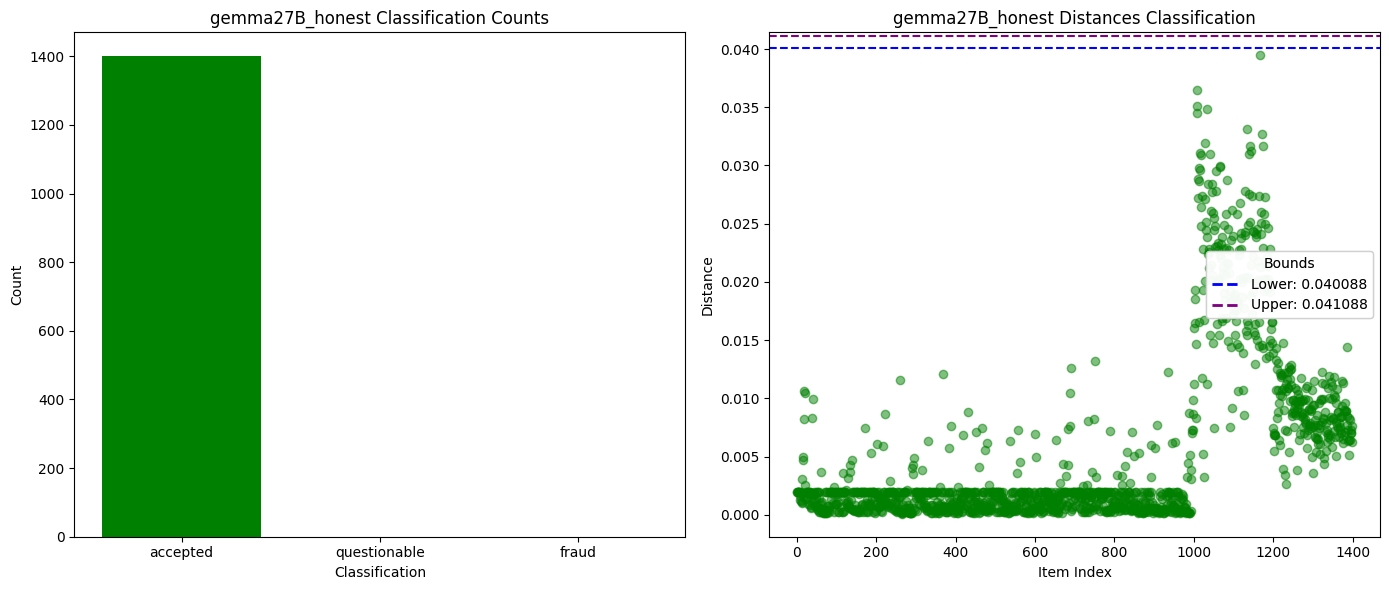

In [6]:
plot_classification_results(
    honest_distances,
    classifications_honest,
    optimal_lower, optimal_upper,
    title_prefix=f"{model_name}_honest",
    # save_to='../data/graphs' 
)

#### Fraud Classification

This plot illustrates how fraudulent inferences produce significantly higher validation distances. The threshold bounds effectively separate fraud cases from honest behavior, with an exceptional **99%** of fraud samples correctly identified in the "fraud" classification zone. This demonstrates excellent separation between the FP8 and INT4 quantized versions of the model.

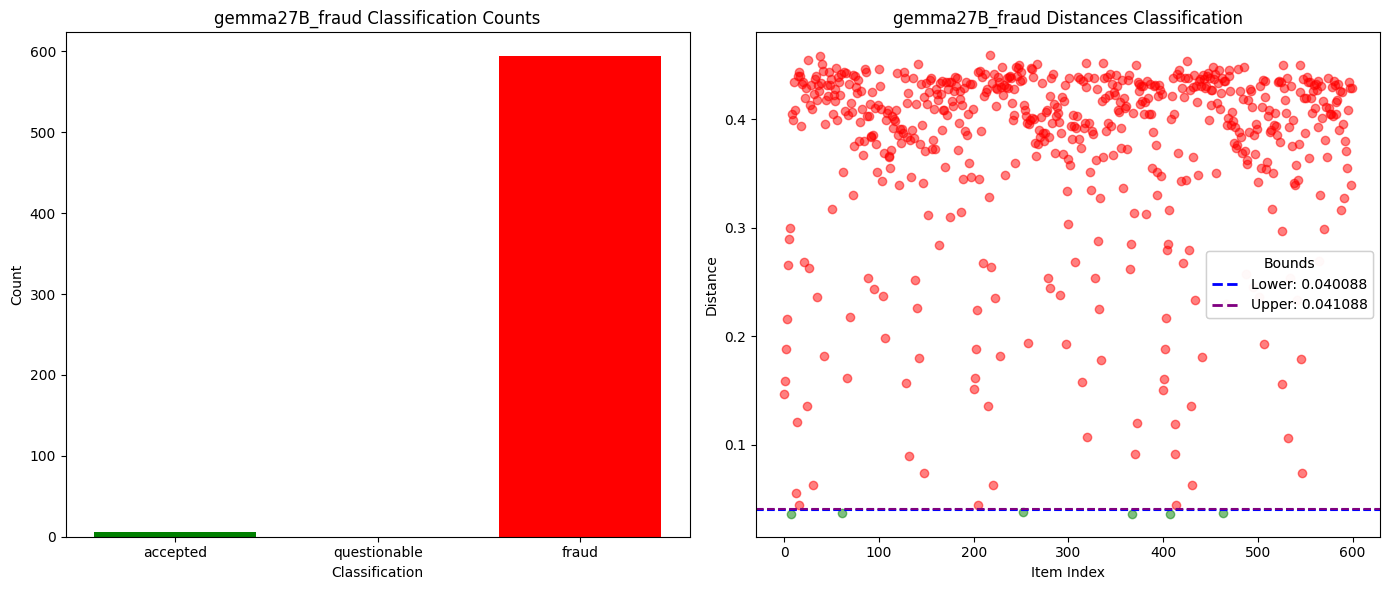

In [7]:
plot_classification_results(
    fraud_distances,
    classifications_fraud,
    optimal_lower,
    optimal_upper,
    title_prefix=f"{model_name}_fraud",
    # save_to='../data/graphs'
)

#### Length vs Distance Comparison

This scatter plot examines the relationship between response length and validation distance across different configurations with different inference request languages. It provides a bird's-eye view to understand the distance distributions.

- **Blue and red/orange points**: honest and fraud inferences
- **Marker shapes**: language of inference request
- **Horizontal lines**: lower and upper threshold bounds

The plot clearly shows excellent separation between honest (blue, clustered near zero) and fraud (red/orange, distributed well above the threshold) inferences, confirming the 99% fraud detection rate.

Share of fraud found = 0.99


/root/gonka/mlnode/packages/benchmarks/src/validation/analysis.py:359: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


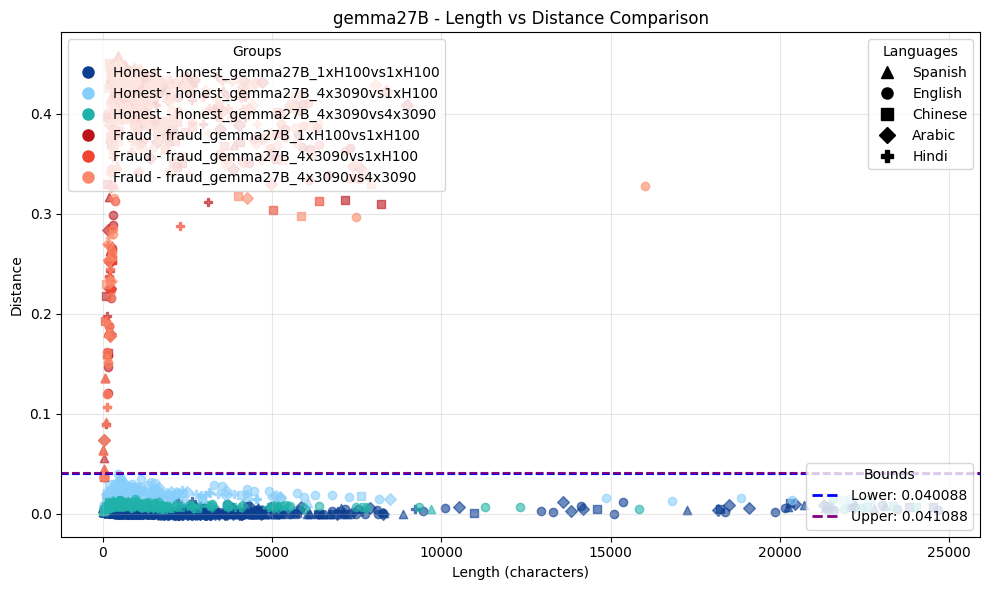

In [8]:
print('Share of fraud found =', sum(np.array(classifications_fraud) == 'fraud')/len(classifications_fraud))
plot_length_vs_distance_comparison(
    model_name,
    honest_items_dict,
    honest_distances_dict,
    fraud_items_dict,
    fraud_distances_dict,
    bounds = (optimal_lower, optimal_upper),
    # save_to='../data/graphs'
)


#### Hardware distances comparison

The violin plots below compare the distances between different hardware configurations.

For honest cycles, there is a clear pattern:
- **1xH100 vs 1xH100**: Lowest distances (mean=0.0016), representing the baseline with minimal hardware variation
- **4x3090 vs 4x3090**: Moderate distances (mean=0.0087), showing some increase with multi-GPU setup
- **4x3090 vs 1xH100**: Highest distances (mean=0.0212), representing cross-hardware validation with the highest variance due to different hardware architectures

Despite the cross-hardware variations, all honest distances remain well below the fraud detection threshold (0.040), ensuring no false positives.

For fraud cycles, distributions are consistently high across all hardware configurations (mean ~0.37), with fraud distances significantly exceeding the threshold regardless of hardware setup. This demonstrates robust fraud detection independent of hardware configuration.

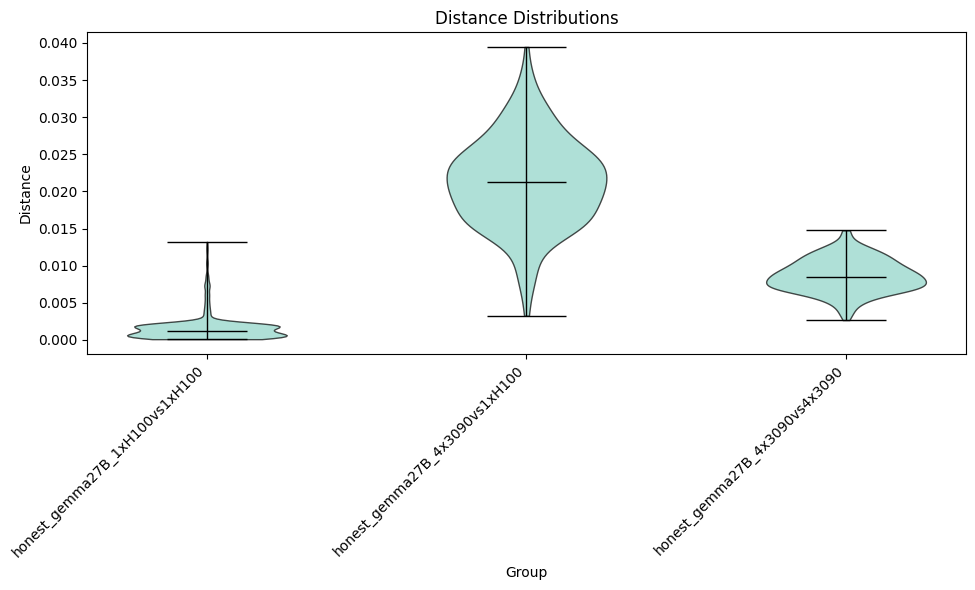

Mean and std per group:
  honest_gemma27B_1xH100vs1xH100: n=1000, mean=0.001562, std=0.001716
  honest_gemma27B_4x3090vs4x3090: n=200, mean=0.008663, std=0.002233
  honest_gemma27B_4x3090vs1xH100: n=200, mean=0.021265, std=0.006092
Delta mean: 0.019703 (honest_gemma27B_1xH100vs1xH100 -> honest_gemma27B_4x3090vs1xH100)
Std range: 0.001716 (honest_gemma27B_1xH100vs1xH100) .. 0.006092 (honest_gemma27B_4x3090vs1xH100)


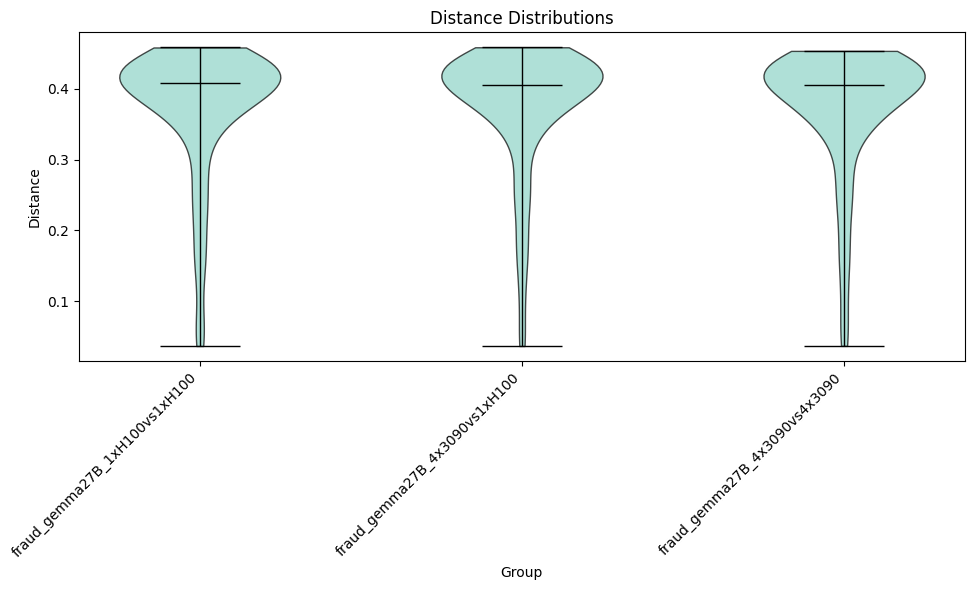

Mean and std per group:
  fraud_gemma27B_4x3090vs4x3090: n=200, mean=0.372408, std=0.090900
  fraud_gemma27B_1xH100vs1xH100: n=200, mean=0.372541, std=0.093152
  fraud_gemma27B_4x3090vs1xH100: n=200, mean=0.375634, std=0.089404
Delta mean: 0.003226 (fraud_gemma27B_4x3090vs4x3090 -> fraud_gemma27B_4x3090vs1xH100)
Std range: 0.089404 (fraud_gemma27B_4x3090vs1xH100) .. 0.093152 (fraud_gemma27B_1xH100vs1xH100)


In [9]:
plot_violin_comparison(honest_distances_dict)
plot_violin_comparison(fraud_distances_dict)

#### Conclusion

The inference results of [gemma-3-27b-it-FP8-dynamic](https://huggingface.co/RedHatAI/gemma-3-27b-it-FP8-dynamic) can be clearly separated from the results of its quantized INT4 version ([gemma-3-27b-it-GPTQ-4b-128g](https://huggingface.co/ISTA-DASLab/gemma-3-27b-it-GPTQ-4b-128g)) with excellent precision. 

With a **99% fraud detection rate** and zero false positives across all hardware configurations tested, the validation thresholds (0.040, 0.041) provide robust protection for the Gonka network. The large separation between honest and fraudulent distances ensures the network will be safe from fraud attempts using quantized versions of this model.